In [1]:
import pandas as pd
from Bio import SeqIO

# 定义FASTA文件路径
file_path = '../manything/9606.protein.sequences.v12.0.fa'

# 创建一个空的列表来存储序列数据
data = []

# 解析FASTA文件
for record in SeqIO.parse(file_path, "fasta"):
    data.append({"id": record.id, "sequence": str(record.seq)})

# 将数据转换为DataFrame
df = pd.DataFrame(data)
print(df.shape)
df.head()

(19699, 2)


,id,sequence
0,9606.ENSP00000000233,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...
1,9606.ENSP00000000412,MFPFYSCWRTGLLLLLLAVAVRESWQTEEKTCDLVGEKGKESEKEL...
2,9606.ENSP00000001008,MTAEEMKATESGAQSAPLPMEGVDISPKQDEGVLKVIKREGTGTEM...
3,9606.ENSP00000001146,MLFEGLDLVSALATLAACLVSVTLLLAVSQQLWQLRWAATRDKSCK...
4,9606.ENSP00000002125,MSVLLRSGLGPLCAVARAAIPFIWRGKYFSSGNEPAENPVTPMLRH...


In [2]:
import pandas as pd
pros = pd.read_csv('../manything/9606.protein.info.v12.0.txt', sep='\t')
pros.head()

,#string_protein_id,preferred_name,protein_size,annotation
0,9606.ENSP00000000233,ARF5,180,ADP-ribosylation factor 5; GTP-binding protein...
1,9606.ENSP00000000412,M6PR,277,Cation-dependent mannose-6-phosphate receptor;...
2,9606.ENSP00000001008,FKBP4,459,"Peptidyl-prolyl cis-trans isomerase FKBP4, N-t..."
3,9606.ENSP00000001146,CYP26B1,512,Cytochrome P450 26B1; Involved in the metaboli...
4,9606.ENSP00000002125,NDUFAF7,441,"Protein arginine methyltransferase NDUFAF7, mi..."


In [3]:
ppis = pd.read_csv('../manything/9606.protein.physical.links.v12.0.txt', sep=' ')
df_merged = ppis.merge(pros[['#string_protein_id', 'preferred_name']], 
                                   left_on='protein1', 
                                   right_on='#string_protein_id', 
                                   how='left')

# 替换 protein1 列
df_merged['protein1'] = df_merged['preferred_name']

# 删除不需要的列
df_merged.drop(columns=['#string_protein_id', 'preferred_name'], inplace=True)

# 替换 protein2 列
df_merged = df_merged.merge(pros[['#string_protein_id', 'preferred_name']], 
                                   left_on='protein2', 
                                   right_on='#string_protein_id', 
                                   how='left')

# 替换 protein1 列
df_merged['protein2'] = df_merged['preferred_name']

# 删除不需要的列
df_merged.drop(columns=['#string_protein_id', 'preferred_name'], inplace=True)

# 打印结果
ppis = df_merged
ppis.head()

,protein1,protein2,combined_score
0,ARF5,NT5E,311
1,ARF5,DUSP3,161
2,ARF5,ARFGAP2,499
3,ARF5,ERP44,531
4,ARF5,TMED10,499


In [4]:
import sys

def display_progress(current, total):
    bar_length = 40  # 进度条长度
    progress = current / total
    arrow = '█' * int(round(progress * bar_length) - 1)
    spaces = ' ' * (bar_length - len(arrow))

    # 构建进度条
    sys.stdout.write(f'\rProgress: |{arrow}{spaces}| {current}/{total} ({progress:.2%})')
    sys.stdout.flush()

In [5]:
df_merged.head()

,protein1,protein2,combined_score
0,ARF5,NT5E,311
1,ARF5,DUSP3,161
2,ARF5,ARFGAP2,499
3,ARF5,ERP44,531
4,ARF5,TMED10,499


In [7]:
import networkx as nx
G = nx.read_gml('graph_ppi_only_p.gml')
# G = nx.read_gexf('../mippi_variation/ppi_network.gexf')
# 创建图
# G = nx.Graph()

# # 添加节点
# for protein in pros['preferred_name']:
#     G.add_node(protein)

# # 添加边及其权重
# num_now = 0
# for _, row in df_merged.iterrows():
#     G.add_edge(row['protein1'], row['protein2'], weight=row['combined_score'])
#     if num_now % 1000 == 0:
#         display_progress(num_now, len(df_merged))
#     num_now = num_now + 1
# # 计算最短路径
# source = 'ARF5'
# target = 'FHDC1'
# shortest_path = nx.shortest_path(G, source=source, target=target, weight='weight')
# shortest_path_length = nx.shortest_path_length(G, source=source, target=target, weight='weight')

# # 输出结果
# print(f"最短路径从 {source} 到 {target}: {shortest_path}")
# print(f"最短路径长度: {shortest_path_length}")
# nx.write_gml(G, 'graph_ppi_only_p.gml')

In [8]:
def get_min(source_node, target_nodes, G):
    shortest_distances = {}
    for target in target_nodes:
        if target in G:
            distance = nx.shortest_path_length(G, source=source_node, target=target)
            shortest_distances[target] = distance

    if shortest_distances:
        min_distance = min(shortest_distances.values())
        # closest_nodes = [node for node, distance in shortest_distances.items() if distance == min_distance]
    else:
        min_distance = None
    return min_distance

In [14]:
import pandas as pd

# 读取 Excel 文件中的所有表格
# file_path = 'protein_net/41588_2018_130_MOESM6_ESM.xlsx'
file_path = '../manything/protein_net/CDH_gene1.xlsx'
sheets = pd.read_excel(file_path, sheet_name=None, header=None)

# 将每个表格存储到单独的 DataFrame
dataframes = {sheet_name: df for sheet_name, df in sheets.items()}
importants = []
# 打印每个 DataFrame 的名称和前几行
for name, df in dataframes.items():
    print(f"表格名称: {name}")
    # print(len(set(df[0].tolist()) & set(pros['preferred_name'].tolist())), len(df[0].tolist()))  # 打印前几行
    print(len([node for node in df[0].tolist() if node in G.nodes]))
    importants.append([node for node in df[0].tolist() if node in G.nodes])


表格名称: Sheet1
73
表格名称: Sheet2
51
表格名称: Sheet3
24
表格名称: Sheet4
12
表格名称: Sheet5
4
表格名称: Sheet6
11
表格名称: Sheet7
33


In [10]:
G.nodes

NodeView(('ARF5', 'M6PR', 'FKBP4', 'CYP26B1', 'NDUFAF7', 'FUCA2', 'HS3ST1', 'SEMA3F', 'CFTR', 'CYP51A1', 'USP28', 'SLC7A2', 'HSPB6', 'PDK4', 'USH1C', 'RALA', 'BAIAP2L1', 'CACNG3', 'TMEM132A', 'DVL2', 'RPAP3', 'SKAP2', 'PRSS21', 'HOXA11', 'CX3CL1', 'TRAPPC6A', 'WDR54', 'SPATA20', 'CEACAM7', 'RHBDD2', 'TSR3', 'OSBPL7', 'YBX2', 'KRT33A', 'TFAP2D', 'CRY1', 'PGLYRP1', 'STARD3NL', 'CAMK1G', 'CD74', 'FAM76A', 'CPA1', 'SYPL1', 'RANBP9', 'CD4', 'TSPAN9', 'QPCTL', 'PPP5C', 'UBR7', 'MAP4K5', 'INMT', 'ERCC1', 'GPRC5A', 'HEBP1', 'COX15', 'MS4A12', 'RGPD5', 'XYLT2', 'SCTR', 'SYT13', 'SNAI2', 'SLC7A9', 'RTF2', 'RB1CC1', 'AKAP11', 'PIGQ', 'CDH17', 'B4GALT7', 'FAM13B', 'CHPF2', 'GABARAPL2', 'MYOC', 'OTC', 'TTC17', 'HOXC8', 'MRI1', 'BOD1L1', 'TARBP1', 'RTN4R', 'PSMA4', 'RIPOR3', 'ZPBP', 'LCP2', 'DCN', 'TNFRSF17', 'MRPS10', 'GUCA1A', 'GRN', 'THAP3', 'VAMP3', 'UTS2', 'RCN1', 'RFC2', 'PPP1R3F', 'NEXMIF', 'ARHGEF5', 'NFE2L3', 'TLL1', 'CBLN4', 'CLDN11', 'FAM168A', 'RELT', 'PKP2', 'YIPF1', 'ADCK2', 'INPP4A', 

In [11]:
def calculate_distances(G, importants):
    """ 计算每个重要节点到所有其他节点的最短距离，并得到最小值 """
    # 存储每个节点到所有其他节点的最短距离
    all_distances_list = []

    # 遍历每个重要节点，计算其到所有其他节点的距离
    for important_list in importants:
        # if important in G:
        all_distances = {}
        for important in important_list:
            distances = nx.single_source_shortest_path_length(G, important)
            all_distances[important] = distances
        all_distances_list.append(all_distances)
    print('done')
    # 存储每个节点到 importants 中节点的最小距离
    min_distances = {}
    # return all_distances
    # 遍历每个节点并计算最小距离
    for node in G.nodes:
        # if node not in importants:
        min_distance = float('inf')
        for important in importants:
            if important in all_distances and node in all_distances[important]:
                min_distance = min(min_distance, all_distances[important][node])
        min_distances[node] = min_distance if min_distance != float('inf') else None
        # print_progress_bar(len(min_distances), leeee)
    return min_distances

# 使用示例
# 假设 G 是你的无向图，importants 是重要节点的列表
# ttt = calculate_distances(G, importants)
# ttt
# min_distances = calculate_distances(G, importants)

In [12]:
import sys
import time

def print_progress_bar(iteration, total, prefix='', suffix='', decimals=1, length=50, fill='█', print_end="\r"):
    """
    调用该函数在循环中打印进度条
    @params:
        iteration   - 当前迭代次数 (Int)
        total       - 总迭代次数 (Int)
        prefix      - 前缀字符串 (Str)
        suffix      - 后缀字符串 (Str)
        decimals    - 进度条百分比的小数位数 (Int)
        length      - 进度条长度 (Int)
        fill        - 进度条填充字符 (Str)
        print_end   - 结束字符 (Str，默认为回车符'\r')
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filled_length = int(length * iteration // total)
    bar = fill * filled_length + '-' * (length - filled_length)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end=print_end)
    # 当完成时打印新行
    if iteration == total: 
        print()

In [15]:
import json
def calculate_distances(G, importants):
    """ 计算每个重要节点到所有其他节点的最短距离，并得到最小值 """
    # 存储每个重要节点到所有其他节点的最短距离
    all_distances = {}

    # 遍历每个重要节点，计算其到所有其他节点的距离
    for important in importants:
        if important in G:
            distances = nx.single_source_shortest_path_length(G, important)
            all_distances[important] = distances
        print_progress_bar(len(all_distances), len(importants))
    # 存储每个节点到 importants 中节点的最小距离
    min_distances = {}

    # 遍历每个节点并计算最小距离
    for node in G.nodes:
        if node not in importants:
            min_distance = float('inf')
            for important in importants:
                if important in all_distances and node in all_distances[important]:
                    min_distance = min(min_distance, all_distances[important][node])
            min_distances[node] = min_distance if min_distance != float('inf') else None
        else:
            min_distances[node] = 0
    return min_distances
dis = []
for i in range(len(importants)):
    min_distances = calculate_distances(G, importants[i])
    dis.append(min_distances)
    with open('distance_CDH_onlt_phy1.json', 'w') as f:
        json.dump(dis, f)




 |██████████████████████████████████████████████████| 100.0% 
 |██████████████████████████████████████████████████| 100.0% 
 |██████████████████████████████████████████████████| 100.0% 
 |██████████████████████████████████████████████████| 100.0% 
 |██████████████████████████████████████████████████| 100.0% 
 |██████████████████████████████████████████████████| 100.0% 
 |██████████████████████████████████████████████████| 100.0% 


In [28]:
with open('manything/distance.json', 'w') as f:
    json.dump(dis, f)

In [10]:
distances = []
for i in range(len(importants)):
    distance = {}
    leeee = len(list(G.nodes))
    for node in list(G.nodes):
        distance[node] = get_min(node, importants[i], G)
        print_progress_bar(len(distance), leeee)
    distances.append(distance)
    print(i)

|██--------------------------------------| 5.44% Complete

KeyboardInterrupt: 

In [9]:
import sys
def print_progress_bar(iteration, total, length=40):
    percent = (iteration / total) * 100
    filled_length = int(length * iteration // total)
    bar = '█' * filled_length + '-' * (length - filled_length)
    sys.stdout.write(f'\r|{bar}| {percent:.2f}% Complete')
    sys.stdout.flush()

/tmp/ipykernel_1472239/1300442255.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


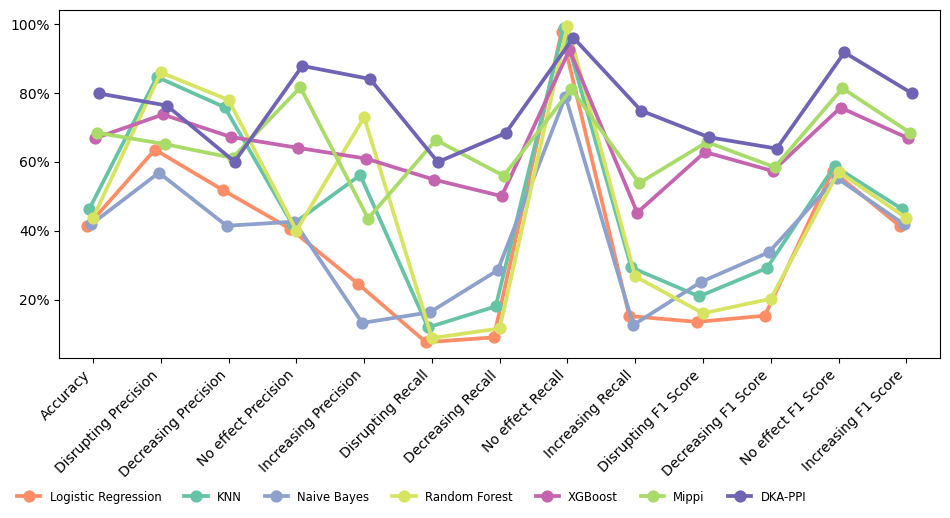

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import FuncFormatter

# 模型名称
models = ['Logistic Regression', 'KNN', 'Naive Bayes', 'Random Forest', 'XGBoost', 'Mippi', 'DKA-PPI']
categories = [
    'Accuracy', 
    'Disrupting Precision', 'Decreasing Precision', 'No effect Precision', 'Increasing Precision',
    'Disrupting Recall', 'Decreasing Recall', 'No effect Recall', 'Increasing Recall',
    'Disrupting F1 Score', 'Decreasing F1 Score', 'No effect F1 Score', 'Increasing F1 Score'
]

# 指标数据
data = [
    [41.2, 63.5, 51.8, 40.5, 24.5, 7.6, 9.0, 97.6, 15.2, 13.5, 15.3, 57.3, 41.2],
    [46.2, 84.6, 75.8, 41.8, 56.1, 11.9, 18.0, 98.8, 29.3, 20.9, 29.1, 58.7, 46.2],
    [41.8, 56.8, 41.4, 42.6, 13.2, 16.3, 28.5, 78.9, 12.6, 25.1, 33.7, 55.3, 41.8],
    [43.7, 85.9, 77.9, 40.0, 72.9, 8.8, 11.6, 99.5, 26.7, 16.0, 20.2, 57.1, 43.7],
    [66.8, 73.7, 67.2, 64.0, 60.9, 54.8, 50.0, 92.5, 45.2, 62.8, 57.3, 75.7, 66.8],
    [68.4, 65.1, 61.1, 81.6, 43.5, 66.3, 55.9, 81.1, 53.8, 65.7, 58.4, 81.3, 68.4],
    [79.8, 76.3, 60.0, 87.8, 84.0, 59.9, 68.3, 96.0, 74.8, 67.1, 63.8, 91.7, 79.8]
]

# 创建 DataFrame
df = pd.DataFrame(data, columns=categories, index=models).reset_index()
df = df.melt(id_vars='index', var_name='Category', value_name='Score')
df.rename(columns={'index': 'Model'}, inplace=True)

# 创建主图
fig, ax = plt.subplots(figsize=(10, 5))
palette = ['#fd8d67', '#66c3a6', '#8ea1cc', '#d6e461', '#c564af', '#a9db69', '#6f64b3']
sns.pointplot(x='Category', y='Score', hue='Model', data=df, dodge=True, palette=palette, ax=ax)

# 设置 x 轴标签倾斜
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# 调整图例位置，减少横向距离
n_models = len(models)
ax.legend(loc='upper center', bbox_to_anchor=(0.4, -0.35), ncol=n_models, frameon=False,
          labelspacing=0.5, fontsize='small')  # 调整 labelspacing 和 fontsize

# 调整底部边距以留出更多空间
plt.subplots_adjust(bottom=0.4)

# 移除 x 轴和 y 轴标签
ax.set_xlabel('')
ax.set_ylabel('')

# 定义格式化函数
def to_percent(y, _):
    return f'{y:.0f}%'

# 应用格式化函数
ax.yaxis.set_major_formatter(FuncFormatter(to_percent))

plt.tight_layout()
plt.show()

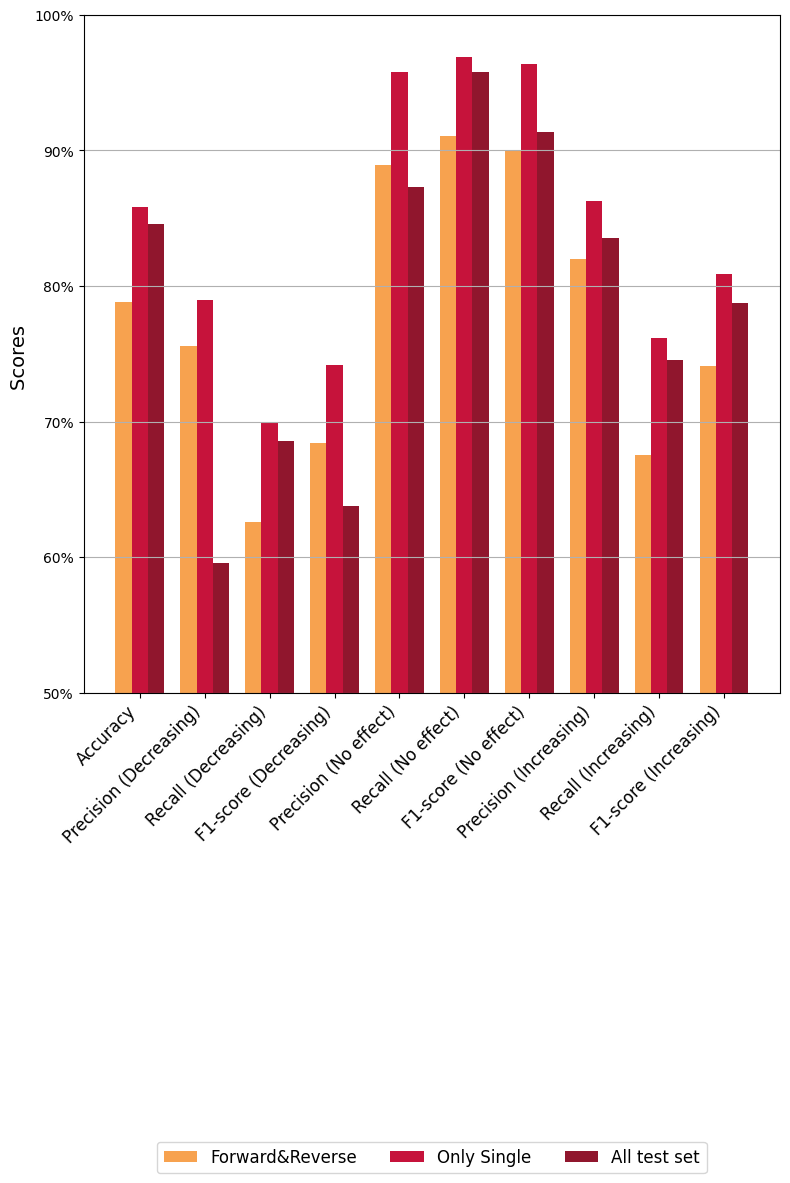

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

# 指标名称
categories = ['Accuracy', 'Precision (Decreasing)', 'Recall (Decreasing)', 'F1-score (Decreasing)',
              'Precision (No effect)', 'Recall (No effect)', 'F1-score (No effect)',
              'Precision (Increasing)', 'Recall (Increasing)', 'F1-score (Increasing)']

# 提供的数据
data = {
    'Forward&Reverse': [78.8, 75.6, 62.6, 68.4, 88.9, 91.1, 90.0, 82.0, 67.5, 74.1],
    'Only Single': [85.8, 79.0, 69.9, 74.2, 95.8, 96.9, 96.4, 86.3, 76.2, 80.9],
    'All test set': [84.6, 59.58, 68.57, 63.76, 87.31, 95.81, 91.36, 83.52, 74.54, 78.78],
}

# 转换数据为numpy数组
data_array = np.array(list(data.values()))

# 设置条形图的参数
bar_width = 0.25
x = np.arange(len(categories))

# 创建图形
fig, ax = plt.subplots(figsize=(8, 10))

# 自定义颜色
colors = ['#F7A24F', '#C6133B', '#90162D']

# 绘制条形图
for i, (model, values) in enumerate(data.items()):
    ax.bar(x + i * bar_width, values, width=bar_width, label=model, color=colors[i])

# 设置标签
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('Scores ', fontsize=14)
# ax.set_title('Model Performance Comparison', fontsize=16)
ax.set_xticks(x + bar_width)
ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=12)

# 格式化 y 轴为百分比
def to_percent(y, _):
    return f'{y:.0f}%'

ax.yaxis.set_major_formatter(FuncFormatter(to_percent))

# 设置 y 轴范围
ax.set_ylim(50, 100)

# 创建额外的空白区域以绘制图例
plt.subplots_adjust(bottom=0.5)  # 调整底部边距以留出更多空间
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.65), ncol=3, fontsize=12)  # 向下移动图例

# 添加网格
ax.yaxis.grid(True)
plt.savefig('manything/photo/plot_9score.png', dpi=300)
plt.tight_layout()
plt.show()

/tmp/ipykernel_4139111/214349806.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=font_size)
/tmp/ipykernel_4139111/214349806.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontsize=font_size)


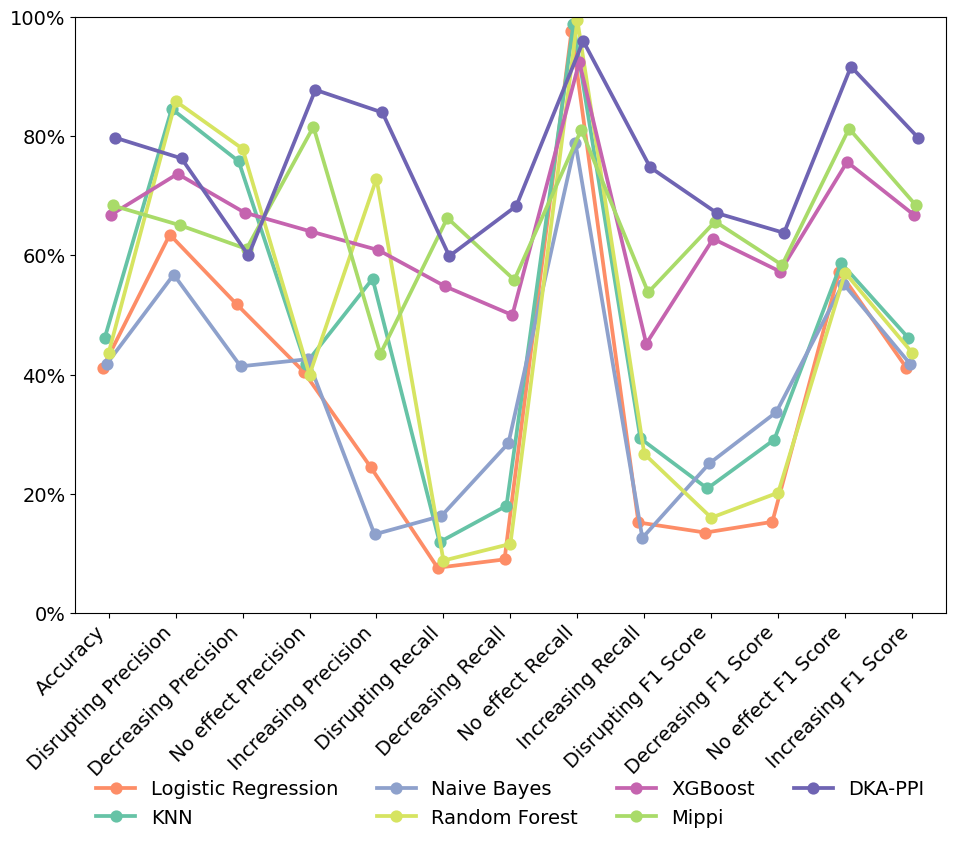

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import FuncFormatter

# 定义字体大小变量
font_size = 14

# 模型名称
models = ['Logistic Regression', 'KNN', 'Naive Bayes', 'Random Forest', 'XGBoost', 'Mippi', 'DKA-PPI']
categories = [
    'Accuracy', 
    'Disrupting Precision', 'Decreasing Precision', 'No effect Precision', 'Increasing Precision',
    'Disrupting Recall', 'Decreasing Recall', 'No effect Recall', 'Increasing Recall',
    'Disrupting F1 Score', 'Decreasing F1 Score', 'No effect F1 Score', 'Increasing F1 Score'
]

# 指标数据
data = [
    [41.2, 63.5, 51.8, 40.5, 24.5, 7.6, 9.0, 97.6, 15.2, 13.5, 15.3, 57.3, 41.2],
    [46.2, 84.6, 75.8, 41.8, 56.1, 11.9, 18.0, 98.8, 29.3, 20.9, 29.1, 58.7, 46.2],
    [41.8, 56.8, 41.4, 42.6, 13.2, 16.3, 28.5, 78.9, 12.6, 25.1, 33.7, 55.3, 41.8],
    [43.7, 85.9, 77.9, 40.0, 72.9, 8.8, 11.6, 99.5, 26.7, 16.0, 20.2, 57.1, 43.7],
    [66.8, 73.7, 67.2, 64.0, 60.9, 54.8, 50.0, 92.5, 45.2, 62.8, 57.3, 75.7, 66.8],
    [68.4, 65.1, 61.1, 81.6, 43.5, 66.3, 55.9, 81.1, 53.8, 65.7, 58.4, 81.3, 68.4],
    [79.8, 76.3, 60.0, 87.8, 84.0, 59.9, 68.3, 96.0, 74.8, 67.1, 63.8, 91.7, 79.8]
]

df = pd.DataFrame(data, columns=categories, index=models).reset_index()
df = df.melt(id_vars='index', var_name='Category', value_name='Score')
df.rename(columns={'index': 'Model'}, inplace=True)

# 创建主图
fig, ax = plt.subplots(figsize=(10, 8))
palette = ['#fd8d67', '#66c3a6', '#8ea1cc', '#d6e461', '#c564af', '#a9db69', '#6f64b3']
sns.pointplot(x='Category', y='Score', hue='Model', data=df, dodge=True, palette=palette, ax=ax)

# 设置字体大小
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=font_size)
ax.set_yticklabels(ax.get_yticks(), fontsize=font_size)

# 添加图例在图的下方，并设置列数
n_models = len(models) // 2 + 1
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=n_models, frameon=False, fontsize=font_size)

# 调整底部边距以留出更多空间
plt.subplots_adjust(bottom=0.6)  # 增加底部的边距

# 移除 x 轴和 y 轴标签
ax.set_xlabel('', fontsize=font_size)
ax.set_ylabel('', fontsize=font_size)

# 定义格式化函数
def to_percent(y, _):
    return f'{y:.0f}%'

# 应用格式化函数
ax.yaxis.set_major_formatter(FuncFormatter(to_percent))
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('manything/photo/plot_13score.png', dpi=300)
plt.show()

/tmp/ipykernel_4139111/3354398721.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=font_size)
/tmp/ipykernel_4139111/3354398721.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontsize=font_size)


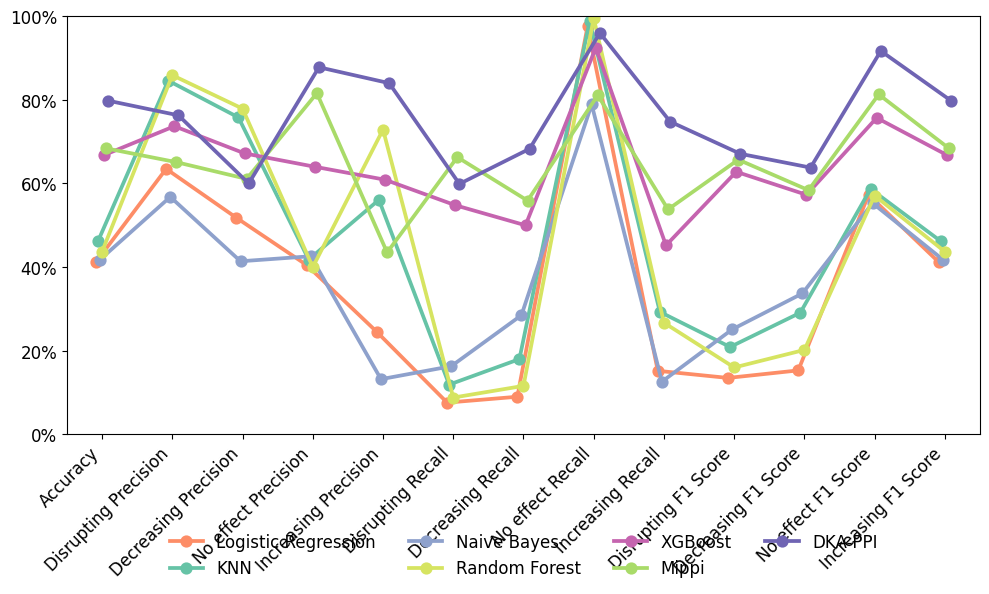

In [18]:
df = pd.DataFrame(data, columns=categories, index=models).reset_index()
df = df.melt(id_vars='index', var_name='Category', value_name='Score')
df.rename(columns={'index': 'Model'}, inplace=True)

# Create the main plot
fig, ax = plt.subplots(figsize=(10, 6))
palette = ['#fd8d67', '#66c3a6', '#8ea1cc', '#d6e461', '#c564af', '#a9db69', '#6f64b3']
sns.pointplot(x='Category', y='Score', hue='Model', data=df, dodge=True, palette=palette, ax=ax)

# Set font size
font_size = 12  # Define your font size
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=font_size)
ax.set_yticklabels(ax.get_yticks(), fontsize=font_size)

# Add legend below the plot
n_models = len(models) // 2 + 1
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), ncol=n_models, frameon=False, fontsize=font_size)

# Adjust bottom margin to leave more space
plt.subplots_adjust(top=1.5,bottom=1.25)  # Increase bottom margin

# Remove x and y axis labels
ax.set_xlabel('', fontsize=font_size)
ax.set_ylabel('', fontsize=font_size)

# Define formatting function
def to_percent(y, _):
    return f'{y:.0f}%'

# Apply formatting function
ax.yaxis.set_major_formatter(FuncFormatter(to_percent))
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('manything/photo/plot_13score.png', dpi=300)
plt.show()

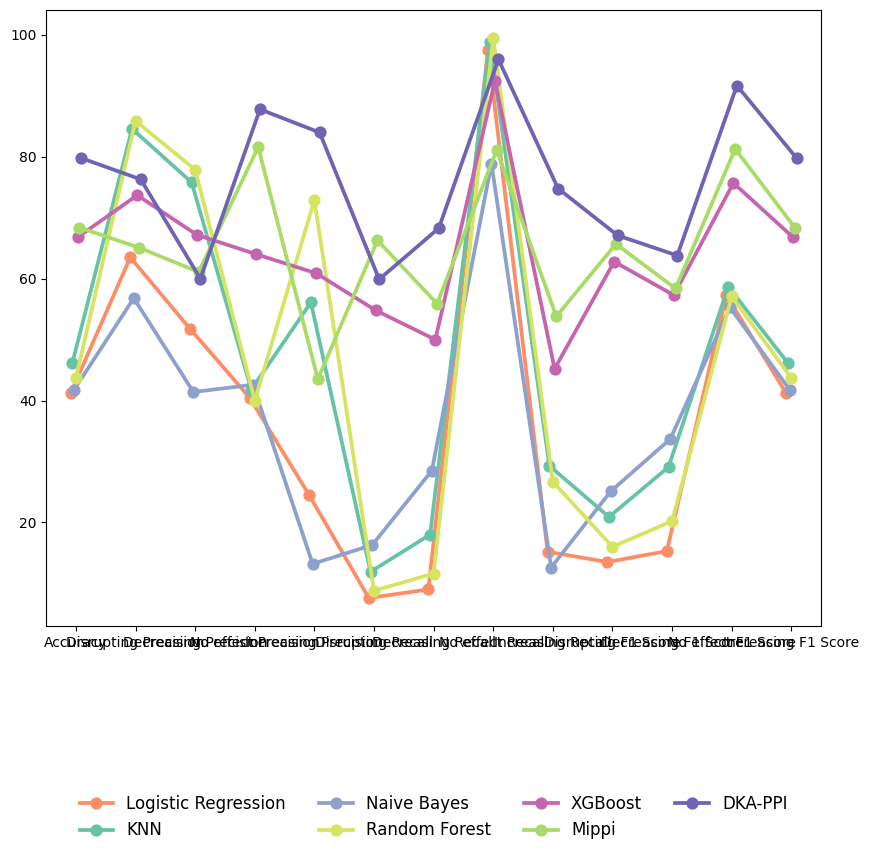

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 data, categories, models, font_size 已经定义

# 创建一个 DataFrame，假设数据已经准备好
df = pd.DataFrame(data, columns=categories, index=models).reset_index()
df = df.melt(id_vars='index', var_name='Category', value_name='Score')
df.rename(columns={'index': 'Model'}, inplace=True)

# 创建主图
fig, ax = plt.subplots(figsize=(10, 8))
palette = ['#fd8d67', '#66c3a6', '#8ea1cc', '#d6e461', '#c564af', '#a9db69', '#6f64b3']
sns.pointplot(x='Category', y='Score', hue='Model', data=df, dodge=True, palette=palette, ax=ax)

# 添加图例
n_models = len(models) // 2 + 1
legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=n_models, frameon=False, fontsize=font_size)

# 移除 x 轴和 y 轴标签
ax.set_xlabel('', fontsize=font_size)
ax.set_ylabel('', fontsize=font_size)

# 保存图例为单独的图像
legend_fig = plt.figure(figsize=(10, 2))  # 图例的大小
legend_ax = legend_fig.add_subplot(111)

# 重新绘制图例
handles, labels = ax.get_legend_handles_labels()
legend_ax.legend(handles, labels, loc='center', ncol=n_models, frameon=False, fontsize=font_size)

# 移除坐标轴
legend_ax.axis('off')

# 保存图例
legend_fig.savefig('manything/photo/legend.png', dpi=300, bbox_inches='tight')
plt.close(legend_fig)  # 关闭图例图像
plt.show()  # 显示主图

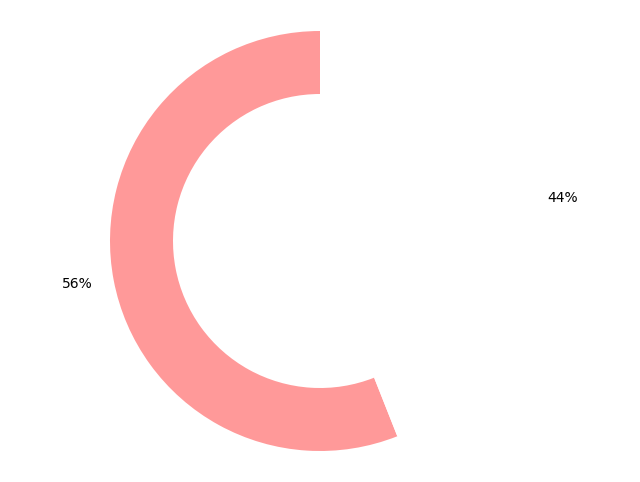

In [3]:
import matplotlib.pyplot as plt

# 数据
sizes = [56, 44]
labels = ['56%', '44%']
colors = ['#ff9999', '#ffffff']

# 绘制环形图
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, startangle=90, wedgeprops=dict(width=0.3))
# plt.title('环形图示例')
plt.axis('equal')
plt.show()

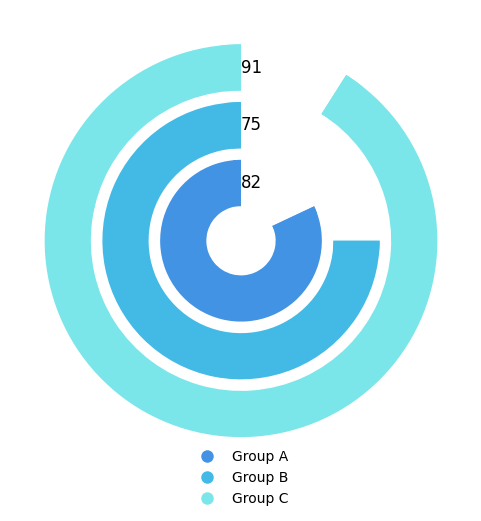

In [23]:
from math import pi
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Create the figure and polar axis
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='polar'))

data = [82, 75, 91]  # Data values
startangle = 90  # Starting angle for bars
colors = ['#4393E5', '#43BAE5', '#7AE6EA']  # Colors for bars

# Convert data to radians
xs = [(i * pi * 2) / 100 for i in data]
ys = [-0.5, 0, 0.5]  # Adjusted Y positions for bars to occupy inner area
left = (startangle * pi * 2) / 360  # Offset for the start of bars

# Plot bars with flat ends
for i, x in enumerate(xs):
    ax.barh(ys[i], x, left=left, height=0.4, color=colors[i])  # Increased height
    
    # Add flat ends using additional bars
    ax.barh(ys[i], 0.1, left=x + left - 0.1, height=0.4, color=colors[i], edgecolor='none')
    ax.barh(ys[i], 0.1, left=left, height=0.4, color=colors[i], edgecolor='none')
    
    # Add annotations at the starting position of each sector
    ax.text(left, ys[i], str(data[i]), fontsize=12, verticalalignment='center', color='black')

# Set limits for Y-axis to reduce center space
plt.ylim(-1, 1)  # Adjusted limits to fit thicker bars

# Add text in the center
# ax.text(0, 0, "中心文本", fontsize=16, ha='center', va='center', color='black', fontweight='bold')

# Create the legend below the plot
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Group A', markerfacecolor='#4393E5', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Group B', markerfacecolor='#43BAE5', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Group C', markerfacecolor='#7AE6EA', markersize=10)
]
plt.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.1), frameon=False)

# Clear ticks, grids, and spines
plt.xticks([])
plt.yticks([])
ax.spines.clear()

# Show the plot
plt.show()

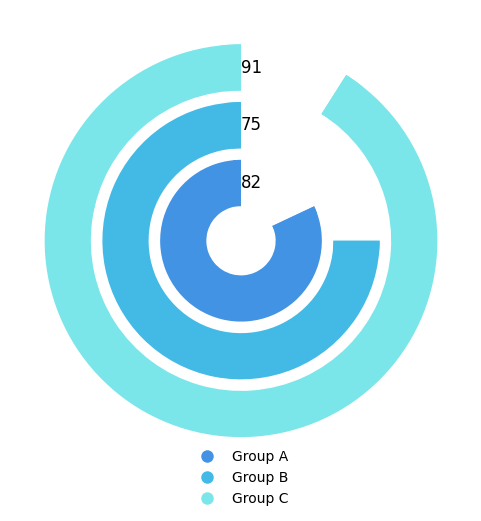

In [20]:
from math import pi
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Create the figure and polar axis
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='polar'))

data = [82, 75, 91]  # Data values
startangle = 90  # Starting angle for bars
colors = ['#4393E5', '#43BAE5', '#7AE6EA']  # Colors for bars

# Convert data to radians
xs = [(i * pi * 2) / 100 for i in data]
ys = [-0.5, 0, 0.5]  # Adjusted Y positions for bars to occupy inner area
left = (startangle * pi * 2) / 360  # Offset for the start of bars

# Plot bars with flat ends
for i, x in enumerate(xs):
    ax.barh(ys[i], x, left=left, height=0.4, color=colors[i])  # Increased height
    
    # Add flat ends using additional bars
    ax.barh(ys[i], 0.1, left=x + left - 0.1, height=0.4, color=colors[i], edgecolor='none')
    ax.barh(ys[i], 0.1, left=left, height=0.4, color=colors[i], edgecolor='none')
    
    # Add annotations at the starting position of each sector
    ax.text(left, ys[i], str(data[i]), fontsize=12, verticalalignment='center', color='black')

# Set limits for Y-axis to reduce center space
plt.ylim(-1, 1)  # Adjusted limits to fit thicker bars

# Create the legend below the plot
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Group A', markerfacecolor='#4393E5', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Group B', markerfacecolor='#43BAE5', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Group C', markerfacecolor='#7AE6EA', markersize=10)
]
plt.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.1), frameon=False)

# Clear ticks, grids, and spines
plt.xticks([])
plt.yticks([])
ax.spines.clear()

# Show the plot
plt.show()